In [2]:
!wget https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy

--2019-08-19 03:52:01--  https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243861814 (233M)
Saving to: ‘bvlc_alexnet.npy’

bvlc_alexnet.npy    100%[===================>] 232.56M  76.6MB/s    in 3.0s    

2019-08-19 03:52:04 (76.6 MB/s) - ‘bvlc_alexnet.npy’ saved [243861814/243861814]



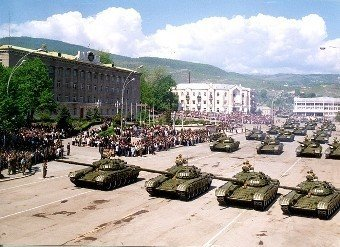

In [4]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('/content/test.jpg')
cv2_imshow(img)
img = cv2.resize(img,(227,227))

In [0]:
import numpy as np
net_data = np.load('/content/bvlc_alexnet.npy', encoding='bytes',allow_pickle=True).item()

In [0]:
def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups =  tf.split(input, group, 3)   
        kernel_groups = tf.split(kernel, group, 3)   
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(output_groups, 3)          
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])

In [0]:
import tensorflow as tf
train_x = np.zeros((1, 227,227,3)).astype(float)
train_y = np.zeros((1, 1000))
xdim = train_x.shape[1:]
ydim = train_y.shape[1]
x = tf.placeholder(tf.float32, (None,) + xdim)

In [8]:
import time
k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
conv1W = tf.Variable(net_data["conv1"][0])
conv1b = tf.Variable(net_data["conv1"][1])
conv1_in = conv(x, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
conv1 = tf.nn.relu(conv1_in)


#lrn1
#lrn(2, 2e-05, 0.75, name='norm1')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn1 = tf.nn.local_response_normalization(conv1,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool1
#max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)


#conv2
#conv(5, 5, 256, 1, 1, group=2, name='conv2')
k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
conv2W = tf.Variable(net_data["conv2"][0])
conv2b = tf.Variable(net_data["conv2"][1])
conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv2 = tf.nn.relu(conv2_in)


#lrn2
#lrn(2, 2e-05, 0.75, name='norm2')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn2 = tf.nn.local_response_normalization(conv2,depth_radius=radius,alpha=alpha,beta=beta,bias=bias)

#maxpool2
#max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#conv3
#conv(3, 3, 384, 1, 1, name='conv3')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
conv3W = tf.Variable(net_data["conv3"][0])
conv3b = tf.Variable(net_data["conv3"][1])
conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv3 = tf.nn.relu(conv3_in)

#conv4
#conv(3, 3, 384, 1, 1, group=2, name='conv4')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
conv4W = tf.Variable(net_data["conv4"][0])
conv4b = tf.Variable(net_data["conv4"][1])
conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv4 = tf.nn.relu(conv4_in)


#conv5
#conv(3, 3, 256, 1, 1, group=2, name='conv5')
k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
conv5W = tf.Variable(net_data["conv5"][0])
conv5b = tf.Variable(net_data["conv5"][1])
conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv5 = tf.nn.relu(conv5_in)

#maxpool5
#max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)


init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

t = time.time()

output = sess.run(maxpool5, feed_dict = {x:[img]})


W0819 03:52:31.615299 140459450296192 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


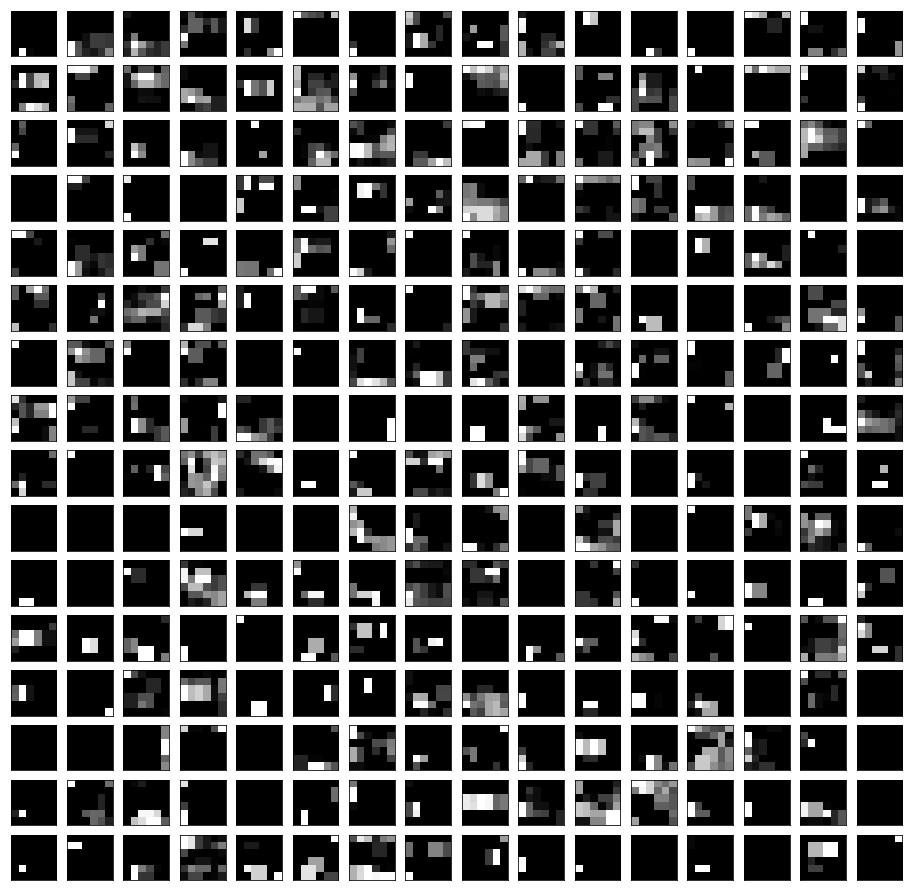

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16, 16))
square = 16
ix =1
for _ in range(square):
  for _ in range(square):
    ax =plt.subplot(square,square,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(output[0,:,:,ix-1],cmap='gray')
    ix+=1
plt.show()   

In [0]:
#Applying the PCA 
import numpy as np
from sklearn.decomposition import PCA
shape = output.shape
img_r = output.reshape(-1,256)
pca = PCA(n_components = 20)
reduced = pca.fit_transform(img_r)

In [50]:
reduced.shape

(36, 20)

In [0]:
modifiedM=reduced.reshape((6,6,20))

In [61]:
modifiedM.shape

(6, 6, 20)

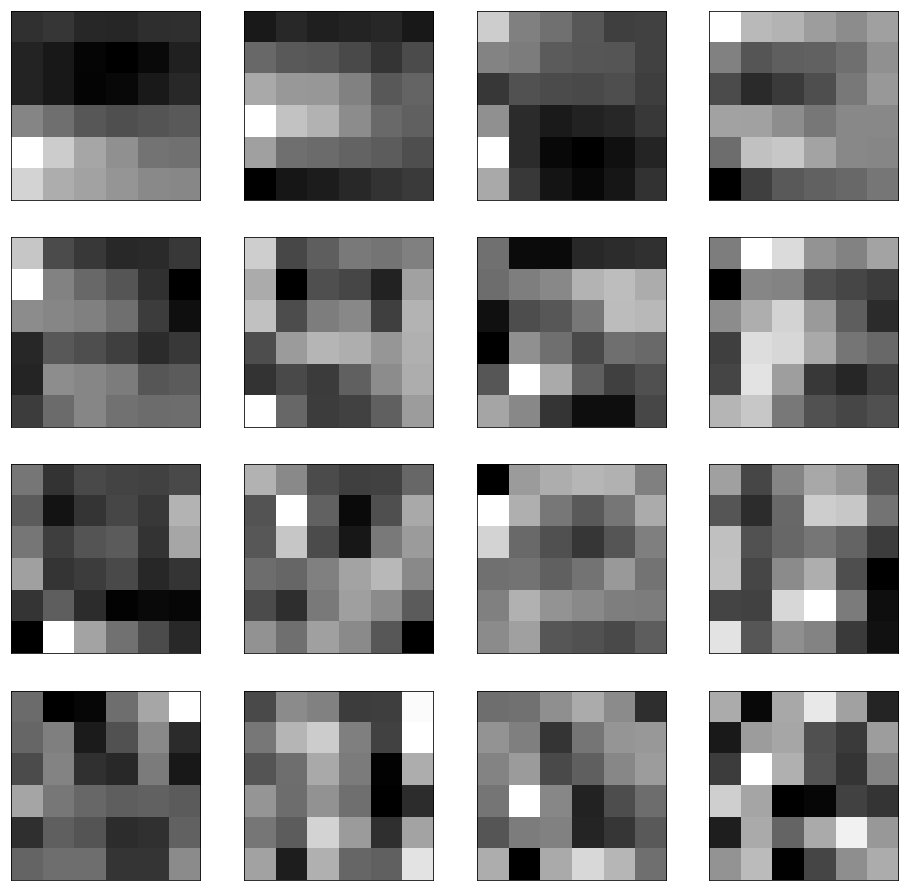

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16, 16))
square = 4
ix =1
for _ in range(square):
  for _ in range(square):
    ax =plt.subplot(square,square,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(modifiedM[:,:,ix-1],cmap='gray')
    ix+=1
plt.show()   

In [94]:
for i in range(0,10):
  print((((modifiedM[:,:,4]-modifiedM[:,:,i])**2).sum())**(0.5))

319.06341209468064
283.2519996619618
250.13385479078997
231.03103653784268
0.0
207.50704054320664
198.6101611039828
193.4941153013445
187.40324586970206
182.15422080273078
